Activity Monitoring
===

 - Cloudfront logs
 - Data dumps

### Cloudfront logs


Query: `SELECT * FROM cloudfront_logs WHERE date >= DATE('2021-09-02') AND uri LIKE '/visit/%' AND query_string LIKE 'utm_source=SSE%';`

### Email batches

In batch 0, email_sent_timestamp is incorrect. First send was at `2021-09-02 14:57:24,997`. Last send was at `2021-09-02 14:59:30,662`.

### Purpose of this notebook

Originally, this notebook was used to explore and produce summary counts.

Now the purpose is to produce three dataframes:
 - batch_df
 - rec_df
 - activity_df

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.family'] = "serif"

In [3]:
import json
import bson
from bson.codec_options import CodecOptions
from bson.raw_bson import RawBSONDocument
from bson import ObjectId
import gzip

import os
from tqdm import tqdm
import pickle
from glob import glob

from datetime import datetime
from dateutil.relativedelta import relativedelta
import dateutil
import pytz

import logging
from pprint import pprint

In [4]:
from pathlib import Path
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = Path(git_root_dir[0].strip())
git_root_dir

PosixPath('/panfs/roc/groups/1/lana/levon003/repos/recsys-peer-match')

In [5]:
import sys
caringbridge_core_path = "/home/lana/levon003/repos/caringbridge_core"
sys.path.append(caringbridge_core_path)

In [6]:
import cbcore.data.paths

In [7]:
assert os.path.exists(cbcore.data.paths.raw_data_filepath)

In [8]:
caringbridge_core_path = "/home/lana/levon003/repos/recsys-peer-match/src"
sys.path.append(caringbridge_core_path)

In [9]:
import cbrec.data

### Loading previous batch recommendations

In [10]:
participant_data_dir = os.path.join(cbcore.data.paths.projects_data_dir, 'recsys-peer-match', 'participant')
!wc -l {participant_data_dir}/*.ndjson

   81928 /home/lana/shared/caringbridge/data/projects/recsys-peer-match/participant/all_author_visits.ndjson
      73 /home/lana/shared/caringbridge/data/projects/recsys-peer-match/participant/participant_rec_data_b0.ndjson
      73 /home/lana/shared/caringbridge/data/projects/recsys-peer-match/participant/participant_rec_data_b10.ndjson
      79 /home/lana/shared/caringbridge/data/projects/recsys-peer-match/participant/participant_rec_data_b1.ndjson
      79 /home/lana/shared/caringbridge/data/projects/recsys-peer-match/participant/participant_rec_data_b2.ndjson
      78 /home/lana/shared/caringbridge/data/projects/recsys-peer-match/participant/participant_rec_data_b3.ndjson
      77 /home/lana/shared/caringbridge/data/projects/recsys-peer-match/participant/participant_rec_data_b4.ndjson
      77 /home/lana/shared/caringbridge/data/projects/recsys-peer-match/participant/participant_rec_data_b5.ndjson
      77 /home/lana/shared/caringbridge/data/projects/recsys-peer-match/participant/p

In [11]:
# load in recommendations from previous rounds
d = []
for batch_id in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    participant_data_filepath = os.path.join(participant_data_dir, f'participant_rec_data_b{batch_id}.ndjson')
    with open(participant_data_filepath, 'r') as infile:
        for line in infile:
            participant = json.loads(line)
            del participant['site_scores']
            participant['batch_id'] = batch_id
            d.append(participant)
len(d)

838

In [ ]:
batch_df = pd.DataFrame(d)
batch_df.head()

In [13]:
list(batch_df.columns)

['participant_id',
 'real_email_address',
 'first_name',
 'feedback_survey_link',
 'sse_site_list',
 'sse_sent_timestamp',
 'batch_id']

In [ ]:
batch_df.sse_site_list.iloc[0][0]

In [15]:
participant_recced_site_map = {}
for participant_id, group in batch_df.groupby('participant_id'):
    recced_site_ids = []
    for sse_site_list in group.sse_site_list:
        recced_site_ids.extend([site['site_id'] for site in sse_site_list])
    assert len(recced_site_ids) == len(set(recced_site_ids)), "Duplicate rec was given."
    recced_site_ids = list(set(recced_site_ids))
    participant_recced_site_map[participant_id] = recced_site_ids
len(participant_recced_site_map)

79

In [17]:
recced_usps = [(row.participant_id, site['site_id']) for row in batch_df.itertuples() for site in row.sse_site_list]
len(recced_usps)

4190

In [18]:
assert len(set(recced_usps)) == len(recced_usps), "Duplicate rec given."

In [19]:
# create rec_df
rec_df = []
for row in batch_df.itertuples(index=False):
    for i, site in enumerate(row.sse_site_list):
        rec = row._asdict()
        del rec['sse_site_list']
        if 'journal_body' in site:
            # some of the data were written with different key names for cleaned_journal_{body,title}
            # this code normalizes the key names
            site = dict(site)
            site['cleaned_journal_body'] = site['journal_body']
            del site['journal_body']
            site['cleaned_journal_title'] = site['journal_title']
            del site['journal_title']
        rec.update(site)
        rec['rank'] = i
        rec_df.append(rec)
rec_df = pd.DataFrame(rec_df)
len(rec_df)

4190

In [20]:
# add alias for participant_id
rec_df['user_id'] = rec_df['participant_id']

In [ ]:
rec_df.sample(n=3)

In [22]:
total_recs = len(rec_df)
total_recced_sites = len(set(rec_df.site_id))
total_participants = len(set(rec_df.user_id))
total_recs, total_recced_sites, total_participants

(4190, 526, 79)

## Participant data

In [ ]:
# get participant data
participant_id_filepath = os.path.join(git_root_dir, 'data/email/participant_ids.tsv')
participant_df = pd.read_csv(participant_id_filepath, sep='\t', header=0)
print(len(participant_df))
participant_df.head()

In [24]:
participant_batch_count_map = batch_df.groupby('participant_id').batch_id.nunique().to_dict()
participant_df['n_total_recs'] = participant_df.user_id.map(lambda user_id: participant_batch_count_map[user_id] * 5 if user_id in participant_batch_count_map else 0)
participant_df.n_total_recs.value_counts()

55    68
0     13
50     5
40     3
45     1
20     1
15     1
Name: n_total_recs, dtype: int64

In [25]:
participant_first_sse_map = batch_df.groupby('participant_id').sse_sent_timestamp.min()
participant_df['first_sse_timestamp'] = participant_df.user_id.map(lambda user_id: participant_first_sse_map[user_id] if user_id in participant_first_sse_map else -1)
participant_df.first_sse_timestamp.value_counts()

 1630612646000    73
-1                13
 1631917513158     1
 1631917455307     1
 1631917496143     1
 1631917519053     1
 1631917494995     1
 1631917489049     1
Name: first_sse_timestamp, dtype: int64

## Cloudfront logs

In [ ]:
# load the logs as a dataframe
s = datetime.now()
cloudfront_filepath = os.path.join(git_root_dir, 'data/cloudfront/cloudfront_sse_visits_20220426.csv')
cf_df = pd.read_csv(cloudfront_filepath, header=0, sep=',')
print(f"Loaded {len(cf_df)} rows in {datetime.now() - s}.")
cf_df.sample(n=10)

In [27]:
timestamps = []
for date, time in tqdm(zip(cf_df.date, cf_df.time), total=len(cf_df)):
    d = datetime.strptime(date + " " + time, '%Y-%m-%d %H:%M:%S').replace(tzinfo=pytz.UTC)
    timestamp = int(d.timestamp())
    timestamps.append(timestamp)
cf_df['timestamp'] = timestamps

100%|██████████| 251/251 [00:00<00:00, 19394.82it/s]


In [27]:
cf_df.method.value_counts()

GET     250
HEAD      1
Name: method, dtype: int64

In [28]:
scf_df = cf_df[cf_df.method == 'GET'].copy()
len(scf_df)

250

In [29]:
def get_utm_info(query_string):
    tokens = query_string.split("&")
    return {token.split("=")[0]: token.split("=")[1] for token in tokens}
new_cols = pd.DataFrame(list(scf_df.query_string.map(get_utm_info)), index=scf_df.index)
#pd.concat([scf_df, new_cols], axis=1)
# add the columns
scf_df = scf_df.merge(new_cols, left_index=True, right_index=True)
scf_df['participant_id'] = scf_df.participant_id.astype(int)
len(scf_df)

250

In [30]:
def get_batch_num(utm_campaign):
    tokens = utm_campaign.split("+")
    if len(tokens) == 2:
        return 0
    else:
        return int(tokens[-1])

scf_df['batch_id'] = scf_df.utm_campaign.map(get_batch_num)
scf_df.batch_id.value_counts()

0     48
3     47
2     33
1     30
5     28
10    19
6     15
8     10
7     10
11     5
9      5
Name: batch_id, dtype: int64

In [31]:
def get_site_name(uri):
    assert uri.startswith('/visit/')
    return uri.split("/")[2]
scf_df['site_name'] = scf_df.uri.map(get_site_name)
scf_df.site_name.nunique()

150

In [ ]:
scf_df.head()

In [33]:
scf_df.utm_campaign.value_counts()

SSE+email       48
SSE+email+3     47
SSE+email+2     33
SSE+email+1     30
SSE+email+5     28
SSE+email+10    19
SSE+email+6     15
SSE+email+8     10
SSE+email+7     10
SSE+email+11     5
SSE+email+9      5
Name: utm_campaign, dtype: int64

In [ ]:
scf_df.groupby('participant_id').batch_id.value_counts().rename('click_count').reset_index().head()

In [ ]:
# in how many batches has a participant participated?
scf_df.groupby('participant_id').batch_id.nunique().rename("batch_participation_count").sort_values(ascending=False).reset_index()

In [ ]:
scf_df.groupby('participant_id').site_name.nunique().rename("unique_site_visit_count").reset_index().sort_values(by='unique_site_visit_count', ascending=False)

In [37]:
scf_df.groupby('participant_id').site_name.nunique().sum()

204

In [ ]:
# merge in participant data
scf_df = scf_df.merge(participant_df, how='left', left_on='participant_id', right_on='user_id', validate='many_to_one')
len(scf_df)

In [ ]:
scf_df.head()

In [ ]:
# identify time_to_click in seconds
time_to_click = scf_df.timestamp - (scf_df.first_sse_timestamp / 1000)
print(f"{np.sum(time_to_click < 0) / len(time_to_click) * 100:.2f}% ({np.sum(time_to_click < 0)}) of clicks happened before the email was sent (due to Zach's testing); median time {np.median(time_to_click[time_to_click < 0]) / 60:.2f}mins")
#time_to_click = np.maximum(time_to_click, 0)
scf_df['time_to_click'] = time_to_click
scf_df[['participant_id', 'time_to_click']].sort_values('time_to_click')

In [41]:
scf_df = scf_df[scf_df.time_to_click > 0]
len(scf_df)

243

In [42]:
# manual exclusion finding
sdf = scf_df[(scf_df.participant_id == 0)&(scf_df.batch_id == 1)].copy()
sdf['iso'] = sdf.timestamp.map(lambda ts: datetime.utcfromtimestamp(ts).isoformat())
sdf[['timestamp', 'iso']]

,timestamp,iso
64,1632604286,2021-09-25T21:11:26
65,1632604341,2021-09-25T21:12:21
66,1632604355,2021-09-25T21:12:35
68,1632604917,2021-09-25T21:21:57
77,1632604651,2021-09-25T21:17:31
93,1632437117,2021-09-23T22:45:17
100,1632436731,2021-09-23T22:38:51
101,1632403755,2021-09-23T13:29:15
132,1633621589,2021-10-07T15:46:29


In [43]:
scf_df = scf_df[~((scf_df.participant_id == 0)&(scf_df.batch_id == 1)&(scf_df.timestamp == 1633621589))]
len(scf_df)

242

In [ ]:
scf_df.groupby('user_id').time_to_click.count().sort_values(ascending=False).rename("total_rec_clicks")

In [45]:
total_rec_clicks = scf_df.groupby('user_id').time_to_click.count().rename("total_rec_clicks")
total_rec_clicks.sum(), total_rec_clicks.count()

(242, 24)

2021-09-02 19:57:26


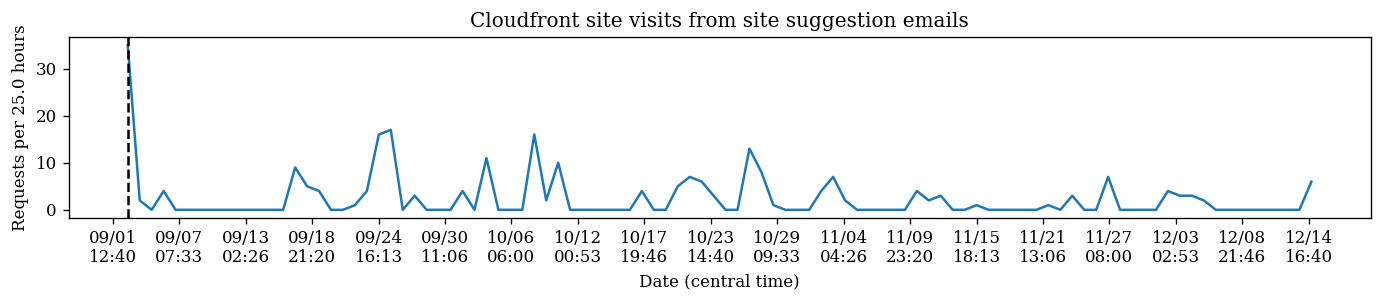

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(14, 2))

bins = 100
counts, bin_edges = np.histogram(scf_df.timestamp, bins=bins)
ax.plot(bin_edges[:-1], counts, label="All visits")

bin_width_s = bin_edges[1] - bin_edges[0]
ax.set_ylabel(f"Requests per {bin_width_s / 60 / 60:.1f} hours")
ax.set_xlabel("Date (central time)")
ax.set_title("Cloudfront site visits from site suggestion emails")

# note this is when the FIRST email was sent in batch 0
ax.axvline(1630612646, linestyle='--', color='black', label='batch')
print(datetime.utcfromtimestamp(1630612646))

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(20)) 
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, y: datetime.utcfromtimestamp(x).replace(tzinfo=pytz.timezone('US/Central')).strftime("%m/%d\n%H:%M")))

plt.show()

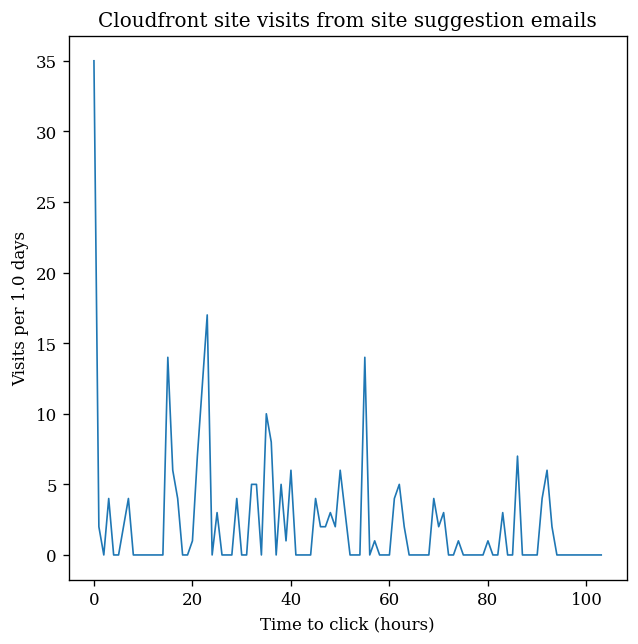

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

xs = scf_df.time_to_click / 60 / 60 / 24
bins = np.arange(xs.min(), xs.max(), 1)
counts, bin_edges = np.histogram(xs, bins=bins)
ax.plot(bin_edges[:-1], counts, label="All visits", linewidth=1)

bin_width_s = bin_edges[1] - bin_edges[0]
ax.set_ylabel(f"Visits per {bin_width_s:.1f} days")
ax.set_xlabel("Time to click (hours)")
ax.set_title("Cloudfront site visits from site suggestion emails")

plt.show()

In [48]:
scf_df.utm_content.value_counts()

visitsite       122
visitjournal    120
Name: utm_content, dtype: int64

In [ ]:
scf_df.participant_id.value_counts()

In [50]:
# total number of participants who clicked a link
len(scf_df.participant_id.value_counts())

24

In [ ]:
scf_df.site_name.value_counts().head()

In [52]:
# number of unique (participant -> site) visit pairs
np.sum(pd.crosstab(scf_df.participant_id, scf_df.site_name).to_numpy() > 0)

199

In [53]:
# number of times a site was visited 2 or more times by a participant
np.sum(pd.crosstab(scf_df.participant_id, scf_df.site_name).to_numpy() >= 2)

33

In [ ]:
pd.crosstab(scf_df.site_name, scf_df.utm_content, margins=True).sort_values('All', ascending=False).head(n=10)

In [ ]:
scf_df.request_ip.value_counts().head()

### Visits and Follows

From the site_profile diffs, look for:
 - Visits to the site
 - Follows of the site
 - Role changes (specifically to "Removed", but anything involving Organizer's is interesting too)

In [26]:
participant_user_ids = set(participant_df[participant_df.n_total_recs > 0].user_id)
len(participant_user_ids)

79

In [27]:
# originally: 920 site_profiles
from cbcore.script.computeCollectionCounts import iterate_collection
# identify site_profiles for participants
site_profiles = []
input_filepath = os.path.join(cbcore.data.paths.raw_data_filepath, 'site_profile.bson.gz')
for doc in tqdm(iterate_collection(input_filepath), desc='Processing documents', total=85713352):
    user_id = int(doc['userId']) if 'userId' in doc else -1
    if user_id in participant_user_ids:
        site_profiles.append(doc)
len(site_profiles)

Processing documents: 86163657it [5:52:31, 4073.60it/s]                                 


920

In [28]:
# save the processed site_profiles to pickle
assert False, "Uncomment this line to overwrite the site_profile pickle file."
assert len(site_profiles) > 0
output_dir = os.path.join(cbcore.data.paths.projects_data_dir, 'recsys-peer-match', 'participant')
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, 'site_profile.pkl'), 'wb') as outfile:
    pickle.dump(site_profiles, outfile)

In [ ]:
# load the site profiles
with open(os.path.join(participant_data_dir, 'site_profile.pkl'), 'rb') as infile:
    site_profiles = pickle.load(infile)
print(len(site_profiles))

# create a dataframe from the site profile entires
ds = []
for sp in site_profiles:
    user_id = int(sp['userId'])
    site_id = int(sp['siteId']) if 'siteId' in sp else -1
    # not capturing: n, nl
    d = {
        'user_id': user_id,
        'site_id': site_id,
        'is_creator': sp['isCreator'] if 'isCreator' in sp else None,
        'is_primary': sp['isPrimary'] if 'isPrimary' in sp else None,
        'role': sp['role'],
        'is_profile_deleted': sp['isProfileDeleted'] if 'isProfileDeleted' in sp else None,
        'is_site_deleted': sp['isSiteDeleted'] if 'isSiteDeleted' in sp else None,
        'is_stub': sp['isStub'] if 'isStub' in sp else None,
        'created_at': sp['createdAt'].timestamp() * 1000 if 'createdAt' in sp else 0,
        'updated_at': sp['updatedAt'].timestamp() * 1000 if 'updatedAt' in sp else 0,
        'n': dict(sp['n']) if 'n' in sp and sp['n'] is not None else {},
    }
    ds.append(d)

ssite_profile_df = pd.DataFrame(ds)
ssite_profile_df.sample(n=10, random_state=0)

In [58]:
ssite_profile_df.role.value_counts()

Visitor      431
Removed      391
Organizer     98
Name: role, dtype: int64

In [ ]:
dict(site_profiles[0])

In [60]:
rsite_profile_df = ssite_profile_df.set_index(['user_id', 'site_id']).sort_index()
rsite_profile_df = rsite_profile_df.loc[rsite_profile_df.index.intersection(recced_usps)].reset_index()
len(rsite_profile_df)

199

In [ ]:
rsite_profile_df.head()

## First clicks analysis

In [62]:
# load the site metadata dataframe
# this is created in caringbridge_core from the new data
site_metadata_working_dir = "/home/lana/shared/caringbridge/data/derived/site_metadata"
s = datetime.now()
site_metadata_filepath = os.path.join(site_metadata_working_dir, "site_metadata.feather")
site_info_df = pd.read_feather(site_metadata_filepath)
assert np.sum(site_info_df.site_id.value_counts() > 1) == 0, "Site ids are not globally unique."
print(datetime.now() - s)
len(site_info_df)

0:00:06.167771


1215739

In [63]:
n_duplicate_names = np.sum(site_info_df.name.value_counts() > 1)
print(f"{n_duplicate_names} ({n_duplicate_names / len(site_info_df):.2%} duplicate site URL names.")

167 (0.01% duplicate site URL names.


In [64]:
# remove duplicate site names from the site_info_df
# keeping the most recent by created_at date
print(len(site_info_df))
site_info_df = site_info_df.sort_values(by='created_at').drop_duplicates(subset='name', keep='last', ignore_index=True)
print(len(site_info_df))

1215739
1215569


In [65]:
# add site_id to the cloudfront data
scf_df = pd.merge(scf_df, site_info_df[['site_id', 'name']], how='left', left_on='site_name', right_on='name', validate='many_to_one')
len(scf_df)

242

In [66]:
first_clicks = scf_df.sort_values(by='timestamp').drop_duplicates(subset=['user_id', 'site_id'], keep='first')
len(first_clicks)

199

In [67]:
first_clicks_map = {(row.user_id, row.site_id): row.timestamp for row in first_clicks.itertuples()}
first_visits_map = {(row.user_id, row.site_id): row.created_at / 1000 for row in rsite_profile_df.itertuples()}
len(first_clicks_map), len(first_visits_map)

(199, 199)

In [68]:
# clicks & logged-in visits are not the same...
set(first_clicks_map.keys()) == set(first_visits_map.keys())

False

In [69]:
all_first_click_or_visit_pairs = set(first_clicks_map.keys()) | set(first_visits_map.keys())
len(all_first_click_or_visit_pairs)

220

In [70]:
participant_rec_map = {}
for user_id, group in batch_df.groupby('participant_id'):
    participant_rec_map[user_id] = []
    for sse in group.itertuples():
        for site in sse.sse_site_list:
            participant_rec_map[user_id].append(site['site_id'])
len(participant_rec_map)

79

In [71]:
participant_rec_time_map = {}
for user_id, group in batch_df.groupby('participant_id'):
    participant_rec_time_map[user_id] = {}
    for sse in group.itertuples():
        for site in sse.sse_site_list:
            participant_rec_time_map[user_id][site['site_id']] = sse.sse_sent_timestamp
len(participant_rec_time_map)

79

In [72]:
n_total = 0
n_visit_only = 0
n_click_only = 0
n_both = 0
n_visit_unrelated_to_rec = 0
n_visit_pre_rec = 0
rec_to_visit_time_diffs = []
click_to_visit_time_diffs = []

for usp in all_first_click_or_visit_pairs:
    if usp in first_clicks_map:
        first_click_ts = first_clicks_map[usp]
    else:
        first_click_ts = None
    if usp in first_visits_map:
        first_visit_ts = first_visits_map[usp]
    else:
        first_visit_ts = None
    
    n_total += 1
    if first_visit_ts and first_click_ts:
        n_both += 1
        click_to_visit_time_diffs.append(first_visit_ts - first_click_ts)
    elif first_visit_ts and not first_click_ts:
        # didn't register click OR visited pre-study
        n_visit_only += 1
        
        user_id, site_id = usp
        # was this site actually recommended?
        was_recced = site_id in participant_rec_map[user_id]
        if not was_recced:
            n_visit_unrelated_to_rec += 1
            continue
        # did this visit occur before the associated recommendation?
        recced_time = participant_rec_time_map[user_id][site_id] / 1000
        rec_to_visit_time_diffs.append(first_visit_ts - recced_time)
        if first_visit_ts < recced_time:
            n_visit_pre_rec += 1
        print(datetime.utcfromtimestamp(recced_time).isoformat())
        
    elif not first_visit_ts and first_click_ts:
        # visit while not logged in
        n_click_only += 1
    elif not first_visit_ts and not first_click_ts:
        raise ValueError("what?")
    else:
        raise ValueError("big what.")
n_total, n_visit_only, n_click_only, n_both, n_visit_unrelated_to_rec, n_visit_pre_rec

2021-09-02T19:57:26
2021-09-02T19:57:26
2021-09-02T19:57:26
2021-09-17T22:24:33.098000
2021-09-02T19:57:26
2021-09-24T16:39:56.622000
2021-09-02T19:57:26
2021-09-02T19:57:26
2021-09-02T19:57:26
2021-09-24T16:39:55.448000
2021-11-17T18:02:58.614000
2021-09-02T19:57:26
2021-11-17T18:02:58.614000
2021-09-02T19:57:26
2021-09-02T19:57:26
2021-11-02T21:23:22.643000
2021-09-02T19:57:26
2021-09-02T19:57:26
2021-09-17T22:24:18.791000
2021-09-02T19:57:26
2021-11-02T21:23:22.643000


(220, 21, 21, 178, 0, 0)

In [73]:
24 / len(scf_df)

0.09917355371900827

In [74]:
# time in hours between rec email sent time and the visit
# no obvious patterns... seems to approximately mirror the distribution of time_to_click
np.array(rec_to_visit_time_diffs) / 60 / 60

array([ 0.25611111,  0.31527778,  1.44333333, 63.44163944,  0.29611111,
       41.54427167,  0.33805556,  1.44611111,  1.43527778,  7.14070889,
        2.857885  ,  1.44861111,  2.89149611,  0.27916667, 14.60166667,
       11.7684325 ,  0.31388889, 14.6275    , 26.14255806, 14.61916667,
       11.70398806])

In [75]:
click_to_visit_time_diffs = np.array(click_to_visit_time_diffs)
len(click_to_visit_time_diffs)

178

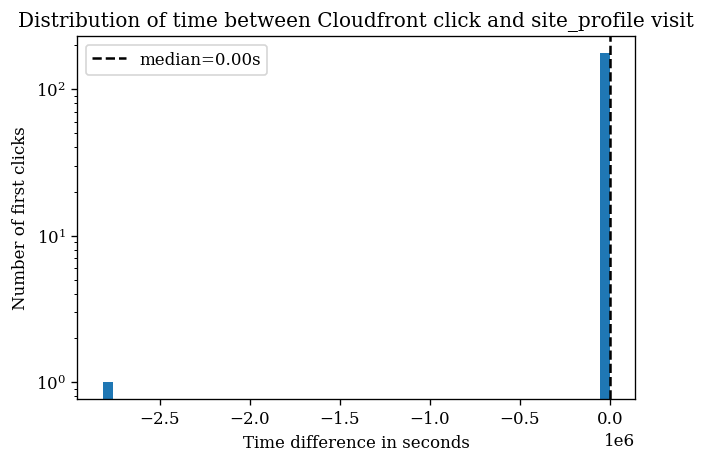

In [76]:
plt.hist(np.minimum(click_to_visit_time_diffs, 100), log=True, bins=50)
plt.axvline(np.median(click_to_visit_time_diffs), label=f"median={np.median(click_to_visit_time_diffs):.2f}s", color='black', linestyle='--')
plt.legend()
plt.title("Distribution of time between Cloudfront click and site_profile visit")
plt.xlabel("Time difference in seconds")
plt.ylabel("Number of first clicks")
plt.show()

In [77]:
# Combine cloudfront and site_profile data into the first_click_map
first_clicks = scf_df.sort_values(by='timestamp').drop_duplicates(subset=['user_id', 'site_id'], keep='first')
first_click_map = {(row.user_id, row.site_id): row.timestamp for row in first_clicks.itertuples()}
for row in rsite_profile_df.itertuples():
    usp = (row.user_id, row.site_id)
    if usp not in first_click_map:
        first_click_map[usp] = int(row.created_at / 1000)
len(first_click_map)

220

In [78]:
first_click_timestamps = []
for row in rec_df.itertuples():
    usp = (row.user_id, row.site_id)
    if usp in first_click_map:
        first_click_timestamp = first_click_map[usp]
    else:
        first_click_timestamp = -1
    first_click_timestamps.append(first_click_timestamp)
# convert to milliseconds
rec_df['first_click_timestamp'] = np.array(first_click_timestamps) * 1000
rec_df['was_clicked'] = rec_df.first_click_timestamp >= 0
rec_df.was_clicked.value_counts()

False    3970
True      220
Name: was_clicked, dtype: int64

In [79]:
f"{np.sum(rec_df.was_clicked) / len(rec_df):.2%} of site recommendations were clicked"

'5.25% of site recommendations were clicked'

In [ ]:
sdf = rec_df[rec_df.was_clicked]
#assert np.all(sdf.first_click_timestamp > sdf.sse_sent_timestamp)
plt.hist((sdf.first_click_timestamp - sdf.sse_sent_timestamp) / 1000 / 60 / 60, bins=np.arange(-5, 100))
plt.xlabel("Time to click (hours)")
plt.ylabel("Distribution of time-to-click")
plt.show()
sdf[(sdf.first_click_timestamp - sdf.sse_sent_timestamp) < 0]

In [81]:
first_click_df = rec_df[rec_df.was_clicked]

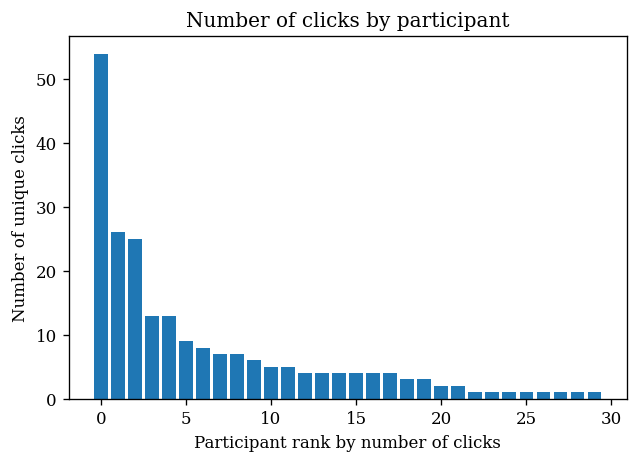

30 220


In [82]:
ys = first_click_df.user_id.value_counts()
xs = range(len(ys))
plt.bar(xs, ys)
plt.title("Number of clicks by participant")
plt.xlabel("Participant rank by number of clicks")
plt.ylabel("Number of unique clicks")
plt.show()
print(np.sum(ys > 0), len(first_click_df))

In [83]:
# compute number of clicks at the batch level
batch_clicked_map = {}
for sse, group in rec_df.groupby(['participant_id', 'batch_id']):
    n_clicked = np.sum(group.was_clicked)
    batch_clicked_map[sse] = n_clicked
n_batch_clicks_list = []
for row in batch_df.itertuples():
    n_batch_clicks = batch_clicked_map[(row.participant_id, row.batch_id)]
    n_batch_clicks_list.append(n_batch_clicks)
batch_df['n_batch_clicks'] = n_batch_clicks_list
batch_df.n_batch_clicks.value_counts()

0    756
1     32
5     20
2     12
4     10
3      8
Name: n_batch_clicks, dtype: int64

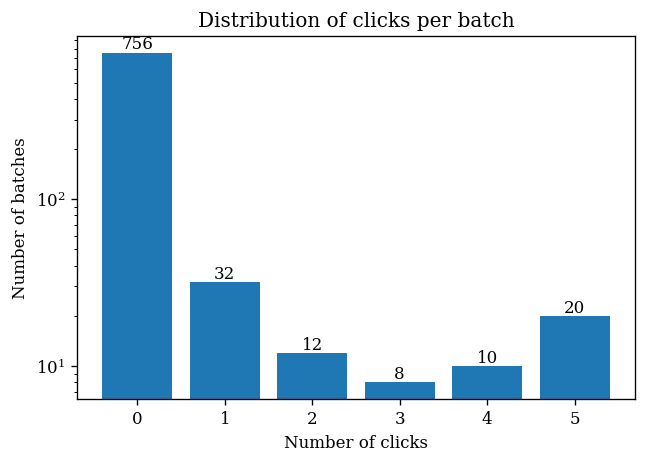

In [84]:
counts, _ = np.histogram(batch_df.n_batch_clicks, bins = np.arange(0, 7))
#plt.hist(batch_df.n_batch_clicks, , log=True)
plt.bar(range(len(counts)), counts)
plt.yscale('log')
for i, count in enumerate(counts):
    plt.text(i, count, f"{count}", ha='center', va='bottom')
plt.xlabel("Number of clicks")
plt.ylabel("Number of batches")
plt.title("Distribution of clicks per batch")
plt.show()

In [ ]:
# six participants clicked every link in an email
batch_df[batch_df.n_batch_clicks == 5].participant_id.value_counts()

#### v1 annotations

Every annotation in a batch that was clicked at least once (but not 5 times).

In [84]:
eligible_batches = [(row.participant_id, row.batch_id) for row in batch_df[(batch_df.n_batch_clicks > 0)&(batch_df.n_batch_clicks < 5)].itertuples()]
len(eligible_batches)

63

In [185]:
header = ['site_id','journal_oid','site_title','cleaned_journal_title','cleaned_journal_body',
          'NOT what/how patient is doing?','good news?','bad news?','EOA/gratitude?','author visible?','expressive writing?']
clicked_batch_sse_annotation_filepath = os.path.join(participant_data_dir, 'clicked_batch_sse_annotation_v1.tsv')

duplicate_avoided = 0
lines_written = 0
written_journal_oids = set()
with open(clicked_batch_sse_annotation_filepath, 'w') as outfile:
    outfile.write('\t'.join(header) + '\n')
    for row in rec_df.sample(frac=1).itertuples():
        if (row.participant_id, row.batch_id) in eligible_batches:
            if row.journal_oid in written_journal_oids:
                duplicate_avoided += 1
                continue
            written_journal_oids.add(row.journal_oid)
            cleaned_journal_title = row.cleaned_journal_title.replace('\t', '    ').replace('\n', ' NEWLINE ').replace('"', '\\"')
            cleaned_journal_body = row.cleaned_journal_body.replace('\t', '    ').replace('\n', ' NEWLINE ').replace('"', '\\"')
            line = f"{row.site_id}\t{row.journal_oid}\t{row.site_title}\t\"{cleaned_journal_title}\"\t\"{cleaned_journal_body}\"\t\t\t\t\t\t\n"
            assert '\n' not in line[:-1]
            outfile.write(line)
            lines_written += 1
lines_written, duplicate_avoided

(242, 73)

In [186]:
with open(clicked_batch_sse_annotation_filepath, 'r') as infile:
    for line in infile:
        tokens = line.split("\t")
        assert len(tokens) == 11, line

In [187]:
len(pd.read_csv(clicked_batch_sse_annotation_filepath, sep='\t', header=0))

242

#### v2 annotations

Every batch from a participant that clicked at least once.

In [87]:
v1_clicked_batch_sse_annotation_filepath = os.path.join(participant_data_dir, 'clicked_batch_sse_annotation_v1.tsv')
v1_journal_oids = set(pd.read_csv(v1_clicked_batch_sse_annotation_filepath, sep='\t', header=0).journal_oid)
len(v1_journal_oids)

242

In [89]:
# identify every participant who clicked at least once
eligible_participants = set([row.participant_id for row in batch_df[batch_df.n_batch_clicks > 0].itertuples()])
# identify all batches already present in the v1 annotations
v1_eligible_batches = [(row.participant_id, row.batch_id) for row in batch_df[(batch_df.n_batch_clicks > 0)&(batch_df.n_batch_clicks < 5)].itertuples()]
# identify all batches NOT in v1 but that are
eligible_batches = [(row.participant_id, row.batch_id) for row in batch_df[batch_df.participant_id.isin(eligible_participants)].itertuples()
                   if (row.participant_id, row.batch_id) not in v1_eligible_batches]
len(eligible_batches)

255

In [90]:
header = ['site_id','journal_oid','site_title','cleaned_journal_title','cleaned_journal_body',
          'NOT what/how patient is doing?','good news?','bad news?','EOA/gratitude?','author visible?','expressive writing?']
clicked_batch_sse_annotation_filepath = os.path.join(participant_data_dir, 'clicked_batch_sse_annotation_v2.tsv')

duplicate_avoided = 0
lines_written = 0
written_journal_oids = set()
with open(clicked_batch_sse_annotation_filepath, 'w') as outfile:
    outfile.write('\t'.join(header) + '\n')
    for row in rec_df.sample(frac=1).itertuples():
        if (row.participant_id, row.batch_id) in eligible_batches:
            if row.journal_oid in written_journal_oids or row.journal_oid in v1_journal_oids:
                duplicate_avoided += 1
                continue
            written_journal_oids.add(row.journal_oid)
            cleaned_journal_title = row.cleaned_journal_title.replace('\t', '    ').replace('\n', ' NEWLINE ').replace('"', '\\"')
            cleaned_journal_body = row.cleaned_journal_body.replace('\t', '    ').replace('\n', ' NEWLINE ').replace('"', '\\"')
            line = f"{row.site_id}\t{row.journal_oid}\t{row.site_title}\t\"{cleaned_journal_title}\"\t\"{cleaned_journal_body}\"\t\t\t\t\t\t\n"
            assert '\n' not in line[:-1]
            outfile.write(line)
            lines_written += 1
lines_written, duplicate_avoided

(376, 899)

In [91]:
len(pd.read_csv(clicked_batch_sse_annotation_filepath, sep='\t', header=0))

376

#### v3 annotations

Random sample of some kind. Sensible options:
 - Random sample of batches (able to answer "what % of batches contained good news?")
 - Random sample of recommended journals (able to answer: "what % of recommendations contained good news?")
 - Random sample of journals, weighted by occurrence (able to answer: "what % of the recommendations viewed by participants contained good news?")

In [94]:
# identify every participant who clicked at least once
eligible_participants = set([row.participant_id for row in batch_df[batch_df.n_batch_clicks > 0].itertuples()])
# identify all batches captured in v1 and v2
v1_v2_eligible_batches = [(row.participant_id, row.batch_id) for row in batch_df[batch_df.participant_id.isin(eligible_participants)].itertuples()]
len(v1_v2_eligible_batches)

318

In [98]:
# TODO figure out how we want to random sample
# keep track of which updates are present in v1_v2_eligible_batches and make sure we don't multiply annotate them...
# this will be somewhat complicated code I think, probably need to change how we sample the rec_df
len(rec_df)

4190

#### Utility bash for copying and transferring files



In [92]:
!cp {clicked_batch_sse_annotation_filepath} .
!pwd
!ls ./*.tsv

/panfs/roc/groups/1/lana/levon003/repos/recsys-peer-match/notebook/survey
./clicked_batch_sse_annotation_v2.tsv


## Visits, but better and more in depth

In [59]:
# load the journal dataframe with the index
s = datetime.now()
journal_metadata_dir = "/home/lana/shared/caringbridge/data/derived/journal_metadata"
journal_metadata_filepath = os.path.join(journal_metadata_dir, "journal_metadata.feather")
journal_df = pd.read_feather(journal_metadata_filepath)
print(datetime.now() - s)
len(journal_df)

0:00:30.553037


21074912

In [60]:
s = datetime.now()
journal_df['usp'] = [(row.user_id, row.site_id) for row in journal_df.itertuples()]
print(datetime.now() - s)

0:01:13.460951


In [ ]:
# load the site profile diff'
# rows should be >= 37M+
s = datetime.now()
site_profile_diff_filepath = os.path.join(cbcore.data.paths.projects_data_dir, 'caringbridge_core', 'site_profile_diff', 'site_profile_diff.tsv')
site_profile_diff_df = pd.read_csv(site_profile_diff_filepath, sep='\t', header=0)
print(f"Read {len(site_profile_diff_df)} rows in {datetime.now() - s}.")
site_profile_diff_df.head()

In [118]:
s = datetime.now()
site_profile_diff_df['usp'] = [(row.user_id, row.site_id) for row in site_profile_diff_df.itertuples()]
print(datetime.now() - s)

0:00:43.472170


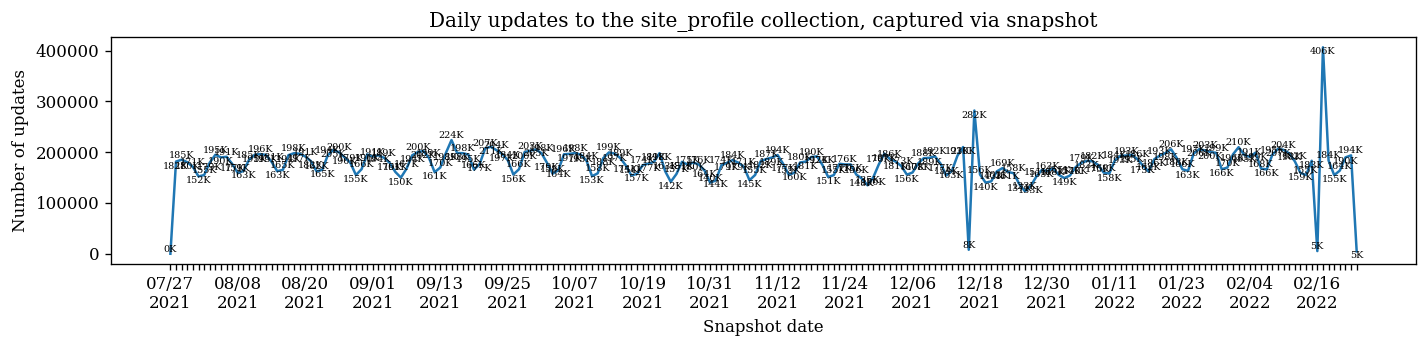

179459.5

In [87]:
daily_counts = site_profile_diff_df.snapshot_date.value_counts().sort_index()

fig, ax = plt.subplots(1, 1, figsize=(12, 3))

xs = np.arange(len(daily_counts))
ax.plot(xs, daily_counts)
nl = '\n'
for x, count in zip(xs, daily_counts):
    ax.text(x, count, f"{count / 1000:,.0f}K", ha='center', va='bottom' if x % 2 == 0 else 'top', fontsize='xx-small')  # {nl if x % 2 == 0 else ''}

ax.set_xticks(xs)
ax.set_xticklabels([f"{str(i)[4:6] + '/' + str(i)[6:8] + nl + str(i)[0:4] if ind % 12 == 0 else ''}" for ind, i in enumerate(daily_counts.index)])

ax.set_title("Daily updates to the site_profile collection, captured via snapshot")
ax.set_xlabel("Snapshot date")
ax.set_ylabel("Number of updates")

plt.tight_layout()
plt.show()

np.median(daily_counts)

In [88]:
site_profile_diff_df.key.value_counts()

updatedAt    36366840
role           507275
n              451935
Name: key, dtype: int64

In [89]:
# note: this is computationally expensive
s = datetime.now()
rsite_profile_diff_df = site_profile_diff_df.set_index(['user_id', 'site_id']).sort_index()
rsite_profile_diff_df = rsite_profile_diff_df.loc[rsite_profile_diff_df.index.intersection(recced_usps)].reset_index()
print(datetime.now() - s)
len(rsite_profile_diff_df)

0:00:41.066611


689

In [ ]:
rsite_profile_diff_df.head()

### New implementation

First and subsequent visits

In [108]:
ssite_profile_df['usp'] = [(row.user_id, row.site_id) for row in ssite_profile_df.itertuples()]

In [103]:
ssite_profile_df['is_self_author'] = (ssite_profile_df.is_creator == 1)|(ssite_profile_df.is_primary == 1)|(ssite_profile_df.role == 'Organizer')
ssite_profile_df.is_self_author.value_counts()

False    822
True      98
Name: is_self_author, dtype: int64

In [104]:
sjournal_df = journal_df[journal_df.user_id.isin(set(ssite_profile_df.user_id))]
len(sjournal_df)

10114

In [105]:
journal_usp_set = set([(row.user_id, row.site_id) for row in sjournal_df.itertuples()])
len(journal_usp_set)

94

In [110]:
# unlike in the pseudo-control group, no issues with authors not being marked as authors but having written journal updates
# however, there are 4 USPs on which a participant is an author but they haven't written any journal updates
pd.crosstab(ssite_profile_df.is_self_author, ssite_profile_df.usp.isin(journal_usp_set).rename("is_journal_author"))

is_journal_author,False,True
is_self_author,,
False,822,0
True,4,94


In [111]:
# redundant with above
ssite_profile_df.loc[ssite_profile_df.usp.isin(journal_usp_set), 'is_self_author'] = True
ssite_profile_df.is_self_author.value_counts()

False    822
True      98
Name: is_self_author, dtype: int64

In [112]:
# create the first_visit_df for others' sites only
# I think this is not used here?
#first_visit_df = ssite_profile_df[~ssite_profile_df.is_self_author]
#len(first_visit_df)

822

In [115]:
# based on journal authors and first visits, identify the set of author USPs (where the user_id is an author of site_id)
author_usp_set = set(ssite_profile_df[ssite_profile_df.is_self_author].usp) | set(journal_df.usp)
len(author_usp_set)

1076259

In [116]:
author_user_id_set = set(ssite_profile_df[ssite_profile_df.is_self_author].user_id) | set(journal_df.user_id)
len(author_user_id_set)

1018067

In [150]:
# author-to-author site visits
# excludes all non-authors
# excludes all self-visits
site_visits = site_profile_diff_df[(site_profile_diff_df.key == 'updatedAt')&(site_profile_diff_df.user_id.isin(author_user_id_set)&(~site_profile_diff_df.usp.isin(author_usp_set)))].copy()
site_visits.key = 'site_profile_diff'
site_visits.new_value = site_visits.new_value.astype(float)
len(site_visits)

1314209

In [ ]:
site_visits.head()

In [152]:
# NOTE: adding the cloudfront data means a given USP is no longer unique within a snapshot
cloudfront_clicks_df = pd.DataFrame([{
    'user_id': row.user_id,
    'site_id': row.site_id,
    'snapshot_date': int((datetime.utcfromtimestamp(row.timestamp) + relativedelta(days=1)).strftime("%Y%m%d")),
    'key': 'cloudfront',
    'old_value': 0,
    'new_value': row.timestamp,
    'usp': (row.user_id, row.site_id),
} for row in scf_df.itertuples()])
print(len(cloudfront_clicks_df))
site_visits = pd.concat([site_visits, cloudfront_clicks_df]).sort_values(by=['new_value'])
len(site_visits)

242


1314451

In [156]:
import bisect
TOLERANCE = 1000 * 60 * 60 * 7  # 7 hours, chosen so that if there's a bug with UTC (5 hours) and DST (1 hour) we still have an hour to treat them as essentially the same time

# instantiate
user_site_interactions = {
    (row.user_id, row.site_id): [row.created_at,] for row in ssite_profile_df[~ssite_profile_df.is_self_author].itertuples()
}
len(user_site_interactions)

n_missing_site_profiles = 0
n_potential_missed_visits = 0
n_empty_curr_values = 0
n_outoforder_inserts = 0
for row in tqdm(site_visits.itertuples(), total=len(site_visits)):
    usp = (row.user_id, row.site_id)
    if usp not in user_site_interactions:
        # these are author interactions, but the author in question is not a participant
        n_missing_site_profiles += 1
        user_site_interactions[usp] = [] #[float(row.old_value) * 1000,] if float(row.old_value) > 0 else [float(row.new_value) * 1000,]
    visit_list = user_site_interactions[usp]
    last_visit = float(row.old_value) * 1000
    curr_visit = float(row.new_value) * 1000
    
    if last_visit > 0 and last_visit not in visit_list:
        bisect.insort_left(visit_list, last_visit)
    assert curr_visit > 0
    if curr_visit not in visit_list:
        bisect.insort_left(visit_list, curr_visit)
    continue
    
    assert curr_visit > 0
    if curr_visit in visit_list:
        continue
    if last_visit == 0:
        n_empty_curr_values += 1
    elif last_visit < visit_list[-1] - TOLERANCE and last_visit not in visit_list:
        logging.warning("updatedAt's old value was before the creation date of the site_profile or before the value from the previous snapshot.")
        print(last_visit, visit_list, curr_visit)
        break
    elif last_visit > visit_list[-1] + 5000:
        n_potential_missed_visits += 1
        visit_list.append(last_visit)
    #assert curr_visit >= visit_list[-1], f"{curr_visit - np.array(visit_list).min()} {np.array(visit_list) - np.array(visit_list).min()}"
    if curr_visit < visit_list[-1]:
        # determine where to insert into the sorted list
        bisect.insort_left(visit_list, curr_visit)
        n_outoforder_inserts += 1
        #visit_list.insert(0, curr_visit)
    else:
        visit_list.append(curr_visit)
n_missing_site_profiles, n_potential_missed_visits, n_outoforder_inserts, len(user_site_interactions)

100%|██████████| 1314451/1314451 [00:05<00:00, 242658.15it/s]


(211649, 0, 0, 212471)

In [157]:
visits_df = pd.DataFrame([{'usp': usp, 'visit_timestamp': visit_timestamp} for usp, visit_list in user_site_interactions.items() for visit_timestamp in visit_list])
visits_df['user_id'] = visits_df.usp.map(lambda usp: usp[0])
visits_df['site_id'] = visits_df.usp.map(lambda usp: usp[1])
len(visits_df)

1527026

In [158]:
# I believe this will result in bucketing by CENTRAL TIME dates
visits_df['visit_date'] = visits_df.visit_timestamp.map(lambda ts: int(datetime.utcfromtimestamp(int(ts / 1000)).strftime('%Y%m%d')))

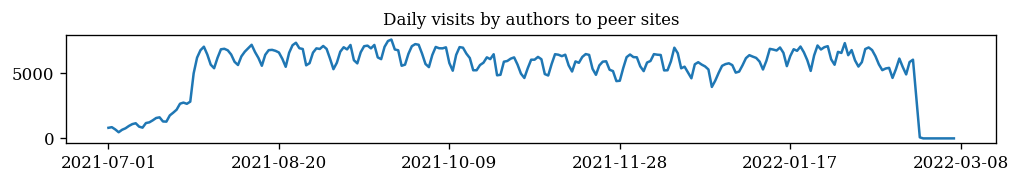

In [159]:
fig, ax = plt.subplots(figsize=(10, 1.2))

start_date = 20210701
daily_visits = visits_df[visits_df.visit_date >= start_date].groupby('visit_date').usp.nunique()

ax.plot(np.arange(len(daily_visits)), daily_visits)
ax.set_title("Daily visits by authors to peer sites", fontsize=10)
def format_date(x, pos=None):
    return f"{(datetime.strptime(str(start_date), '%Y%m%d') + relativedelta(days=int(x))).strftime('%Y-%m-%d')}"
ax.xaxis.set_major_formatter(format_date)

plt.show()

In [160]:
svisits_df = visits_df[visits_df.usp.isin(recced_usps)]
len(svisits_df)

1033

In [166]:
# how many "return visits" are there?
def count_return_visits(visit_timestamps, hour_threshold=7):
    if len(visit_timestamps) <= 1:
        return 0
    return_visit_threshold = 1000 * 60 * 60 * hour_threshold  # hour_threshold hours
    
    n_return_visits = 0
    first_timestamp = visit_timestamps[0]
    for timestamp in visit_timestamps[1:]:
        if timestamp > first_timestamp + return_visit_threshold:
            n_return_visits += 1
    return n_return_visits
ds = []
for usp, visit_timestamps in user_site_interactions.items():
    ds.append({
        'usp': usp,
        'n_repeat_visits_7hr': count_return_visits(visit_timestamps, hour_threshold=7),
        'n_days_visited': count_return_visits(visit_timestamps, hour_threshold=24),
    })
repeat_visit_df = pd.DataFrame(ds)
repeat_visit_df = repeat_visit_df[repeat_visit_df.usp.isin(recced_usps)]
repeat_visit_df['user_id'] = [usp[0] for usp in repeat_visit_df.usp]
repeat_visit_df['site_id'] = [usp[1] for usp in repeat_visit_df.usp]
len(repeat_visit_df)

220

In [ ]:
repeat_visit_df.head()

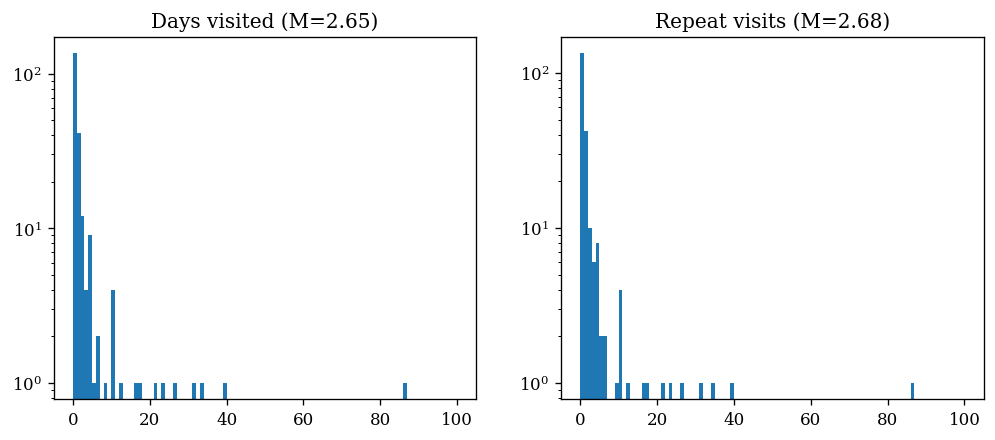

In [172]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
xs = repeat_visit_df.n_days_visited
ax.hist(xs, bins=np.arange(0, xs.max()), log=True)
ax.set_title(f"Days visited (M={xs.mean():.2f})")

ax = axes[1]
xs = repeat_visit_df.n_repeat_visits_7hr
ax.hist(xs, bins=np.arange(0, xs.max()), log=True)
ax.set_title(f"Repeat visits (M={xs.mean():.2f})")

plt.show()

In [233]:
repeat_visit_df.n_repeat_visits_7hr.sum()  # collectively, participants made 589 repeat visits

589

In [178]:
c = (repeat_visit_df.n_repeat_visits_7hr > 0).sum()
c, c / total_recs

(86, 0.02052505966587112)

In [180]:
c = len(set(repeat_visit_df[repeat_visit_df.n_repeat_visits_7hr > 0].user_id))
c, c / total_participants

(17, 0.21518987341772153)

In [183]:
c = len(repeat_visit_df[repeat_visit_df.n_repeat_visits_7hr > 0].groupby('site_id').user_id.count())
c, c / total_recced_sites

(76, 0.1444866920152091)

In [184]:
# compute counts for first clicks as well
c = len(repeat_visit_df)
c, c / total_recs

(220, 0.05250596658711217)

In [185]:
c = len(set(repeat_visit_df.user_id))
c, c / total_participants

(30, 0.379746835443038)

In [186]:
c = len(set(repeat_visit_df.site_id))
c, c / total_recced_sites

(158, 0.30038022813688214)

## Follow actions

In [ ]:
# follow actions
sp_df[sp_df.key == 'n']

In [191]:
notification_updates = site_profile_diff_df[(site_profile_diff_df.key == 'n')&(site_profile_diff_df.user_id.isin(participant_user_ids))].copy()
notification_updates['usp'] = [(row.user_id, row.site_id) for row in notification_updates.itertuples()]
notification_updates = notification_updates[notification_updates.usp.isin(recced_usps)].copy()
len(notification_updates)

11

In [202]:
follow_actions = []
for row in notification_updates.itertuples():
    #print(row.old_value)
    assert pd.isna(row.old_value)
    print(row.new_value)
    follow_actions.append((row.user_id, row.site_id))
len(follow_actions)

{'j': ['email', 'android', 'iphone'], 'sa': ['email']}
{'j': ['email', 'android', 'iphone']}
{'j': ['email', 'android', 'iphone']}
{'j': ['email', 'android', 'iphone']}
{'j': ['email', 'android', 'iphone']}
{'j': ['email', 'android', 'iphone']}
{'j': ['email', 'android', 'iphone']}
{'j': ['email', 'android', 'iphone']}
{'j': []}
{'j': ['email', 'android', 'iphone']}
{'j': [], 'sa': []}


11

In [ ]:
# currently, this is a reasonable estimate of number of follow actions
sp_df[sp_df.n.map(lambda n: len(n) > 0)].groupby(['user_id', 'site_id']).updated_at.nunique()

In [204]:
follow_df = sp_df[sp_df.n.map(lambda n: len(n) > 0)].groupby(['user_id', 'site_id']).updated_at.nunique().reset_index()
follow_df['usp'] = [(row.user_id, row.site_id) for row in follow_df.itertuples()]
assert len(set(follow_actions) - set(follow_df.usp)) == 0, "Additional follow actions not captured in the site_profile collection"
#len(follow_df)

In [208]:
len(follow_df)

24

In [ ]:
follow_df

In [213]:
# compute counts for follows
c = len(follow_df)
c, c / total_recs

(24, 0.005727923627684964)

In [214]:
c = len(set(follow_df.user_id))
c, c / total_participants

(5, 0.06329113924050633)

In [215]:
c = len(set(follow_df.site_id))
c, c / total_recced_sites

(23, 0.043726235741444866)

In [216]:
c = 1
c / total_recs, c / total_participants, c / total_recced_sites

(0.00023866348448687351, 0.012658227848101266, 0.0019011406844106464)

In [101]:
sp_df.n.map(lambda n: len(n)).value_counts()

1    355
0    268
4    106
2     37
Name: n, dtype: int64

In [102]:
pd.crosstab(sp_df.key, sp_df.n.map(lambda n: len(n)), dropna=False)

n,0,1,2,4
key,,,,
n,0,9,2,0
role,95,9,4,1
updatedAt,96,337,31,105


In [128]:
del site_profile_diff_df

## Interactions and journals

In [97]:
# journals used to be loaded here, now loaded above

In [ ]:
# read interactions dataframe
s = datetime.now()
model_data_dir = '/home/lana/shared/caringbridge/data/projects/recsys-peer-match/model_data'
ints_df = pd.read_feather(os.path.join(model_data_dir, 'ints_df.feather'))
print(f"Read {len(ints_df)} rows ({len(set(ints_df.user_id))} unique users) in {datetime.now() - s}.")
ints_df.head()

In [29]:
participant_user_ids = set(participant_df[participant_df.n_total_recs > 0].user_id)
len(participant_user_ids)

79

In [30]:
pints_df = ints_df[ints_df.user_id.isin(participant_user_ids)].copy()
pints_df['usp'] = [(row.user_id, row.site_id) for row in pints_df.itertuples()]
len(pints_df)

31140

In [31]:
pints_df = pints_df[pints_df.usp.isin(recced_usps)]
len(pints_df)

948

In [32]:
# compute counts for initiations
rec_c = len(set(pints_df.usp))
user_c = len(set(pints_df.user_id))
site_c = len(set(pints_df.site_id))
print(f"{rec_c} & {rec_c / total_recs:.1%} & {user_c} & {user_c / total_participants:.1%} & {site_c} & {site_c / total_recced_sites:.1%}")

36 & 0.9% & 9 & 11.4% & 33 & 6.3%


In [33]:
# compute counts for interactions
rec_c = len(pints_df)
user_c = len(set(pints_df.user_id))
site_c = len(set(pints_df.site_id))
print(f"{rec_c} & n/a & {user_c} & {user_c / total_participants:.1%} & {site_c} & {site_c / total_recced_sites:.1%}")

948 & n/a & 9 & 11.4% & 33 & 6.3%


In [34]:
# compute counts for text interactions
sdf = pints_df[~pints_df.interaction_type.str.startswith('amp')]
rec_c = len(sdf)
user_c = len(set(sdf.user_id))
site_c = len(set(sdf.site_id))
print(f"{rec_c} & n/a & {user_c} & {user_c / total_participants:.1%} & {site_c} & {site_c / total_recced_sites:.1%}")

268 & n/a & 4 & 5.1% & 20 & 3.8%


In [ ]:
site_int_counts = pints_df.groupby('site_id').user_id.count().rename("int_counts")
print(f"Sites received Median={site_int_counts.median()} and Mean={site_int_counts.mean():.2f} (SD={site_int_counts.std():.2f}) interactions")
site_int_counts.sort_values(ascending=False).head(15)

In [ ]:
pints_df.groupby(['user_id', 'site_id']).interaction_oid.count()

#### Sidebar: how many initiations happened during the study period but NOT related to the study?

In [42]:
first_sse_timestamp = batch_df.sse_sent_timestamp.min()
first_sse_time = datetime.utcfromtimestamp(first_sse_timestamp / 1000)
print(f"First SSE sent: {first_sse_time}")

last_sse_timestamp = batch_df.sse_sent_timestamp.max()
last_sse_time = datetime.utcfromtimestamp(last_sse_timestamp / 1000)
print(f"Last SSE sent: {last_sse_time}")

First SSE sent: 2021-09-02 19:57:26
Last SSE sent: 2021-11-24 17:57:12.174000


In [43]:
days_10 = 1000 * 60 * 60 * 24 * 10
# note that we have to do this annoying pre-study thing due to missing timestamps on the dates
pinits_df = pints_df[(pints_df.created_at >= first_sse_timestamp - days_10)&(pints_df.created_at <= last_sse_timestamp)].sort_values(by='created_at').drop_duplicates(subset='usp', keep='first')
len(pinits_df)

30

In [44]:
datetime.utcfromtimestamp(pinits_df.created_at.min() / 1000).isoformat(), datetime.utcfromtimestamp(pinits_df.created_at.max() / 1000).isoformat()

('2021-08-23T21:49:57.122000', '2021-11-18T23:07:41.673000')

In [47]:
sints_df = ints_df[(ints_df.created_at >= first_sse_timestamp - days_10)&(ints_df.created_at <= last_sse_timestamp)].copy()
sints_df['usp'] = [(user_id, site_id) for user_id, site_id in zip(sints_df.user_id, sints_df.site_id)]
inits_df = sints_df.sort_values(by='created_at').drop_duplicates(subset='usp', keep='first')
len(inits_df)

62105

In [53]:
# Our study accounted for less than 0.05% of the initiations...
f"{len(pinits_df) / len(inits_df):.3%} of initiations during the study period"

'0.048% of initiations during the study period'

In [55]:
n_initiating_participants = len(set(pinits_df.user_id)) + 1  # for the person who we accidentally excluded with the time window
n_initiating_nonp = len(set(inits_df.user_id))
n_initiating_participants, n_initiating_nonp

(9, 46986)

In [71]:
len(pinits_df) / 79  # number of initiations / eligible authors who participated

0.379746835443038

In [61]:
author_set = set(journal_df[journal_df.published_at <= last_sse_timestamp].user_id)
len(author_set)

983741

In [62]:
active_author_set = set(journal_df[(journal_df.published_at <= first_sse_timestamp - days_10)&(journal_df.published_at <= last_sse_timestamp)].user_id)
len(active_author_set)

973112

In [77]:
len(inits_df[inits_df.user_id.isin(active_author_set)])

53284

In [79]:
len(set(inits_df[inits_df.user_id.isin(active_author_set)].user_id))

39503

In [80]:
79 / 39503

0.0019998481128015596

In [72]:
print(len(inits_df) / len(active_author_set))
len(inits_df[inits_df.user_id.isin(active_author_set - participant_user_ids)]) / len(active_author_set - participant_user_ids)

0.06382101957431416


0.054640433941671104

In [69]:
len(participant_user_ids), len(participant_user_ids - active_author_set)  # only one participant not in the active author set

(79, 1)

In [73]:
len(inits_df[inits_df.user_id.isin(participant_user_ids)])

118

In [74]:
# recommendation-caused initiations constitute 
30 / 118

0.2542372881355932

In [75]:
(30 + 88) / 88

1.3409090909090908

In [78]:
118 / 53284

0.002214548457323024

#### Older analysis of initiations and interactions:

In [ ]:
participant_ints_df = ints_df[ints_df.user_id.isin(participant_user_ids)]
participant_ints_df = participant_ints_df.set_index(['user_id', 'site_id']).sort_index()
print(len(participant_ints_df))
participant_ints_df.head()

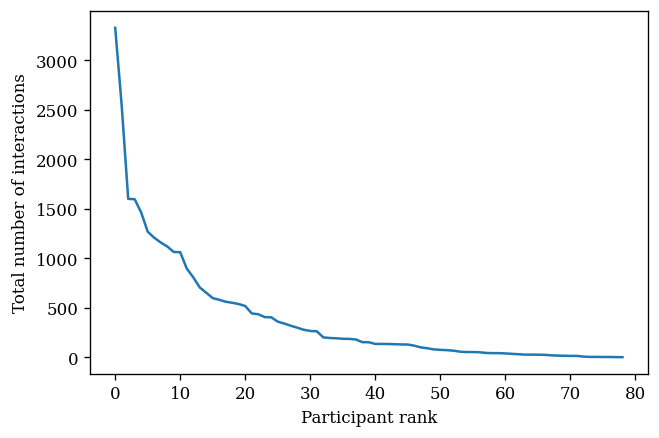

In [133]:
total_int_count = participant_ints_df.groupby('user_id').created_at.count().rename('total_int_count').sort_values(ascending=False)
plt.plot(range(len(total_int_count)), total_int_count)
plt.ylabel("Total number of interactions")
plt.xlabel("Participant rank")
plt.show()

In [134]:
rec_ints_df = participant_ints_df.loc[participant_ints_df.index.intersection(recced_usps)].reset_index()
len(rec_ints_df)

948

In [ ]:
rec_ints_df.groupby('user_id').site_id.count().sort_values(ascending=False)

In [ ]:
pd.crosstab(rec_ints_df.user_id, rec_ints_df.interaction_type)

In [138]:
rec_ints_df.interaction_type.value_counts()

amp                 598
comment             266
amp_heart            41
amp_folded_hands     34
amp_sad               5
amp_happy             2
guestbook             2
Name: interaction_type, dtype: int64

In [ ]:
participant_df.head()

In [63]:
days30 = 1000 * 60 * 60 * 24 * 30
first_sse_timestamp_map = participant_df.set_index('user_id').first_sse_timestamp.to_dict()

ds = []
for user_id, group in participant_ints_df.groupby('user_id'):
    if user_id not in first_sse_timestamp_map:
        print("PANIC")
        continue
    first_sse_timestamp = first_sse_timestamp_map[user_id]
    if first_sse_timestamp == -1:
        continue
    n_total = len(group)
    n_post = np.sum(group.created_at >= first_sse_timestamp)
    n_pre = n_total - n_post
    
    
    n_post_30 = np.sum((group.created_at >= first_sse_timestamp)&(group.created_at <= first_sse_timestamp + days30))
    n_pre_30 = np.sum((group.created_at <= first_sse_timestamp)&(group.created_at >= first_sse_timestamp - days30))
    d = {
        'user_id': user_id,
        'n_pre_30': n_pre_30, 
        'n_post_30': n_post_30,
    }
    ds.append(d)
    
int_count_df = pd.DataFrame(ds)
len(int_count_df)

78

28.21% greater, 17.95% equal, 53.85% less interactions, when comparing 30 days post-study-start and 30 days pre-study-start


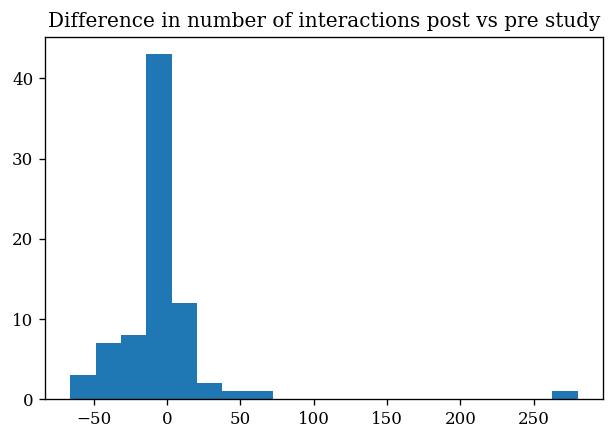

In [71]:
xs = int_count_df.n_post_30 - int_count_df.n_pre_30
print(f"{np.sum(xs > 0) / len(xs):.2%} greater, {np.sum(xs == 0) / len(xs):.2%} equal, {np.sum(xs < 0) / len(xs):.2%} less interactions, when comparing 30 days post-study-start and 30 days pre-study-start")
plt.hist(xs, bins=20)
plt.title("Difference in number of interactions post vs pre study")
plt.show()

In [ ]:
# TODO compare the pre and post interactions between the participants and the "pseudo-control" non-participants